[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\omar2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omar2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


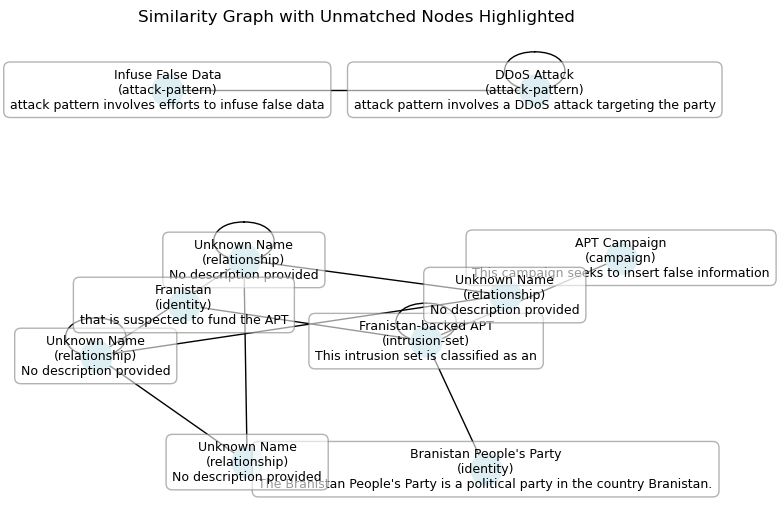

Unmatched Nodes:


In [3]:
import os
import json
import nltk
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the spaCy NLP model
nlp = spacy.load('en_core_web_sm')

# Ensure resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

def load_json(file_path):
    """Load JSON data from a file."""
    with open(file_path, 'r') as file:
        return json.load(file)

def json_to_text(data):
    texts = []
    ids = []
    json_objects = {}
    for entry in data:
        text = ". ".join(f"{key}: {value}" if not isinstance(value, list) else f"{key}: " + ", ".join(map(str, value)) for key, value in entry.items())
        texts.append(text)
        ids.append(entry['id'])
        json_objects[entry['id']] = entry
    return texts, ids, json_objects

def preprocess_json_objects(json_objects):
    for key, obj in json_objects.items():  # Ensure you iterate over items(), not the dictionary itself
        if 'name' not in obj:
            obj['name'] = 'Unknown Name'
        if 'type' not in obj:
            obj['type'] = 'Unknown Type'
        if 'description' not in obj:
            obj['description'] = 'No description provided'
    return json_objects




def extract_verb_centered_snippet(description, window=2, max_gap=4):
    """Extract snippets around the first two verbs found in the description."""
    doc = nlp(description)
    verbs = []
    for token in doc:
        if token.pos_ == 'VERB':
            verbs.append((token.i, token))
            if len(verbs) == 2:
                break

    if not verbs:
        return description

    if len(verbs) == 1:
        start = max(0, verbs[0][1].i - window)
        end = min(len(doc), verbs[0][1].i + window + 1)
        return doc[start:end].text

    v1, v2 = verbs
    if (v2[0] - v1[0]) <= max_gap:
        start = max(0, v1[1].i - window)
        end = min(len(doc), v2[1].i + window + 1)
        return doc[start:end].text
    else:
        snippet1 = doc[max(0, v1[1].i - window):v1[1].i + window + 1].text
        snippet2 = doc[max(0, v2[1].i - window):v2[1].i + window + 1].text
        return f"{snippet1} ... {snippet2}"

def visualize_similarity_graph(G, unmatched_nodes):
    """Visualize a networkx graph with enhanced label formatting for readability."""
    # Using Kamada-Kawai layout for improved visualization aesthetics
    pos = nx.kamada_kawai_layout(G, scale=2)

    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=500, font_size=10)

    labels = {}
    for node, data in G.nodes(data=True):
        label = f"{data['label']}\n({data.get('type', '')})"
        description = data.get('description', '')
        if description:
            snippet = extract_verb_centered_snippet(description)
            label += f"\n{snippet}"
        labels[node] = label

    for node, label in labels.items():
        x, y = pos[node]
        plt.text(x, y, label, fontsize=9, ha='center', va='center',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='gray', alpha=0.6))

    plt.title('Similarity Graph with Unmatched Nodes Highlighted')
    plt.show()

    # Print unmatched nodes
    print("Unmatched Nodes:")
    for node in unmatched_nodes:
        print(f"{node}: {G.nodes[node]['label']}")


def main():
    path1 = input("Enter the file path for JSON 1: ").strip('"')
    path2 = input("Enter the file path for JSON 2: ").strip('"')

    data1 = load_json(path1)
    data2 = load_json(path2)

    texts1, ids1, json_objects1 = json_to_text(data1)
    texts2, ids2, json_objects2 = json_to_text(data2)

    json_objects1 = preprocess_json_objects(json_objects1)
    json_objects2 = preprocess_json_objects(json_objects2)

    vectorizer = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords.words('english'))
    tfidf1 = vectorizer.fit_transform(texts1)
    tfidf2 = vectorizer.transform(texts2)

    similarity_matrix = cosine_similarity(tfidf1, tfidf2)

    G = nx.Graph()
    threshold = 0.5
    unmatched_nodes = []

    for i, row in enumerate(similarity_matrix):
        for j, similarity in enumerate(row):
            if similarity > threshold:
                G.add_node(ids1[i], label=json_objects1[ids1[i]]['name'], type=json_objects1[ids1[i]]['type'], description=json_objects1[ids1[i]]['description'])
                G.add_node(ids2[j], label=json_objects2[ids2[j]]['name'], type=json_objects2[ids2[j]]['type'], description=json_objects2[ids2[j]]['description'])
                G.add_edge(ids1[i], ids2[j], weight=similarity)

    for id1 in ids1:
        if not any(similarity_matrix[i][j] > threshold for j in range(len(ids2))):
            unmatched_nodes.append(id1)
            G.add_node(id1, label=json_objects1[id1]['name'], type=json_objects1[id1]['type'], description=json_objects1[id1]['description'])

    for id2 in ids2:
        if not any(similarity_matrix[i][j] > threshold for i in range(len(ids1))):
            unmatched_nodes.append(id2)
            G.add_node(id2, label=json_objects2[id2]['name'], type=json_objects2[id2]['type'], description=json_objects2[id2]['description'])

    visualize_similarity_graph(G, unmatched_nodes)

if __name__ == "__main__":
    main()

